In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, load_model

In [5]:
def normalization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
def norm_all(data):
    d = np.empty((data.shape[0], data.shape[1], data.shape[2]))
    for i in range(data.shape[1]):
        data1 = data[:, i, :]
        for j in range(data1.shape[0]):
            data2 = data1[j, :]
            d[j, i, :] = normalization(data2)
    return d
def normal_label(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = np.zeros(np.shape(data))
    m = data.shape[0]
    normData = data - np.tile(minVals, (m, 1))
    normData = normData / np.tile(ranges, (m, 1))
    return normData[0]
data_x1 = norm_all(data_x1)
data_x4 = norm_all(data_x4)
data_x6 = norm_all(data_x6)
data_x11 = norm_all(data_x11)
data_x41 = norm_all(data_x41)
data_x61 = norm_all(data_x61)
data_y1 = normal_label(data_y1)
data_y4 = normal_label(data_y4)
data_y6 = normal_label(data_y6)

In [6]:
train_x = np.append(data_x1, data_x4, axis=0)
train_y = np.append(data_y1, data_y4, axis=0)
train_x1 = np.append(data_x11, data_x41, axis=0)
test_x = data_x6
test_x1 = data_x61
test_y = data_y6
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
# seed = 344  #91
# np.random.seed(seed)
# random.seed(seed)
# tf.random.set_seed(seed)
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=14, kernel_size=6, activation='relu', input_shape=(6, 24)))
cnn_model.add(Flatten()) 
train_x_cnn_features = cnn_model.predict(train_x)
test_x_cnn_features = cnn_model.predict(test_x)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


C:\Users\Yuxinning\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


In [8]:
# seed = 100   #34
# np.random.seed(seed)
# random.seed(seed)
# tf.random.set_seed(seed)
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=14, kernel_size=6, activation='relu', input_shape=(6, 12)))
cnn_model.add(Flatten())
train_x_cnn_features1 = cnn_model.predict(train_x1)
test_x_cnn_features1 = cnn_model.predict(test_x1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


In [9]:
train_x_cnn_features = np.reshape(train_x_cnn_features, (train_x_cnn_features.shape[0],train_x_cnn_features.shape[1],1))
test_x_cnn_features = np.reshape(test_x_cnn_features, (test_x_cnn_features.shape[0],test_x_cnn_features.shape[1],1))
train_x_cnn_features1 = np.reshape(train_x_cnn_features1, (train_x_cnn_features1.shape[0],train_x_cnn_features1.shape[1],1))
test_x_cnn_features1 = np.reshape(test_x_cnn_features1, (test_x_cnn_features1.shape[0],test_x_cnn_features1.shape[1],1))

In [10]:
import numpy as np
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, Input, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
class TransformerEncoder(layers.Layer):
    def __init__(self,
                 head_size, 
                 num_heads, 
                 ff_dim,
                 dropout=0
                ):
        super(TransformerEncoder, self).__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout   
        self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.multihead_attention = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )
        self.dropout_1 = layers.Dropout(0.2)
        self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.conv1d_1 = layers.Conv1D(filters=6, kernel_size=1, activation="relu")
        self.dropout_2 = layers.Dropout(0.2)
        self.conv1d_2 = layers.Conv1D(filters=1, kernel_size=1)
    def call(self, inputs):
        x = self.layer_norm_1(inputs)
#         x = tf.expand_dims(x,axis=1)
        attention_output = self.multihead_attention(x, x)
        x = self.dropout_1(attention_output)
        res = x + inputs
        x = self.layer_norm_2(res)
        x = self.conv1d_1(x)
        x = self.dropout_2(x)
        x = self.conv1d_2(x)
        output = x + res   
        return output

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, que_dim, key_dim, num_heads=4, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super(CrossAttention, self).__init__()
        self.que_dim = que_dim
        self.key_dim = key_dim
        self.num_heads = num_heads
        head_dim = que_dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5 
        # Query, Key, and Value transformations
        self.q_transform = tf.keras.layers.Dense(que_dim, use_bias=qkv_bias)
        self.k_transform = tf.keras.layers.Dense(que_dim, use_bias=qkv_bias)
        self.v_transform = tf.keras.layers.Dense(que_dim, use_bias=qkv_bias)   
        # Dropout layers
        self.attn_drop = tf.keras.layers.Dropout(attn_drop)
        self.proj = tf.keras.layers.Dense(que_dim)
        self.proj_drop = tf.keras.layers.Dropout(proj_drop)
    def call(self, x, embedding):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        E_N, E_C = tf.shape(embedding)[1], tf.shape(embedding)[2]
        # Transform query, key, and value
        q = self.q_transform(x)
        k = self.k_transform(embedding)
        v = self.v_transform(embedding)
        # Reshape for multi-head attention
        q = tf.reshape(q, (B, N, self.num_heads, self.que_dim // self.num_heads))
        k = tf.reshape(k, (B, E_N, self.num_heads, self.que_dim // self.num_heads))
        v = tf.reshape(v, (B, E_N, self.num_heads, self.que_dim // self.num_heads))
        # Transpose dimensions to match (B, num_heads, N, head_dim)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        k = tf.transpose(k, perm=[0, 2, 1, 3])
        v = tf.transpose(v, perm=[0, 2, 1, 3])
        # Scaled dot-product attention
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        # Compute the output
        output = tf.matmul(attn, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (B, N, self.que_dim))     
        # Final linear projection
        output = self.proj(output)
        output = self.proj_drop(output)
        return x + output
class attention(layers.Layer):
    def __init__(self, att_size, att_heads, att_ff_dim, att_dropout=0):
        super(attention, self).__init__()
        self.head_size = att_size
        self.num_heads = att_heads
        self.ff_dim = att_ff_dim
        self.dropout = att_dropout      
        self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.cross_attention = CrossAttention(que_dim=128, key_dim=256, num_heads=4) 
        self.dropout_1 = layers.Dropout(0.25)
        self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.conv1d_1 = layers.Conv1D(filters=4, kernel_size=1, activation="relu")
        self.dropout_2 = layers.Dropout(0.2)
        self.conv1d_2 = layers.Conv1D(filters=1, kernel_size=1)
    def call(self, inputs1, inputs2):
        x1 = inputs1
        x2 = inputs2
        attention_output = self.cross_attention(x1, x2)
        weighted_average = tf.multiply(attention_output, x2) + x1
        output = weighted_average
        x = self.layer_norm_2(output)
        x = self.conv1d_1(x)
        x = self.dropout_2(x)
        x = self.conv1d_2(x)
        output = x + output
        return output

In [12]:
class LSTMDecoder(layers.Layer):
    def __init__(self, hidden_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
#         self.input_size = input_size
        self.Lstm1 = layers.LSTM(units = 256,return_sequences=True)
#         self.Dropout1 = layers.Dropout(0.2)
        self.Lstm2 = layers.LSTM(units= 256,return_sequences=True)
#         self.Dropout2 = layers.Dropout(0.2)
        self.Lstm3 = layers.LSTM(units = 512,return_sequences=True)
        self.Dropout3 = layers.Dropout(0.1)
        self.Dense = layers.Dense(units = 256, activation='relu')
    def call(self, inputs):
        x1 = self.Lstm1(inputs)
#         x = self.Dropout1(x)
        x2 = self.Lstm2(x1)
#         x = self.Dropout2(x)
        x = self.Lstm3(x1+x2)
        x = self.Dropout3(x)
        output = self.Dense(x)
        #x = self.Dense(x[:,-1,:])
        return output

In [13]:
def build_model():
    inp1 = Input(shape = (14,1))
    inp2 = Input(shape = (14,1))
    x1 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(inp1)
    x2 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(x1)
    x3 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(x2)   
    x5 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(inp2)
    x6 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(x5)
    x7 = TransformerEncoder(head_size=512, num_heads=4, ff_dim=4, dropout=0.1)(x6)  
    x = attention(att_size=256, att_heads=8, att_ff_dim=8, att_dropout=0.2)(x3,x7)
    x = LSTMDecoder(hidden_size=256)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    x = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(x) 
    model = Model(inputs=[inp1, inp2], outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = keras.optimizers.Adam(learning_rate=5e-4))
    return model

In [14]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow import keras
model = build_model()
model.summary()

C:\Users\Yuxinning\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 14, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 14, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder           │ (None, 14, 1)             │          14,360 │ input_layer_3[0][0]        │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_3         │ (None, 14, 1)             │          14,360 │ input_layer_4[0][0]        │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_1         │ (None, 14, 1)             │          14,360 │ transformer_encoder[0][0]  │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_4         │ (None, 14, 1)             │          14,360 │ transformer_encoder_3[0][… │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_2         │ (None, 14, 1)             │          14,360 │ transformer_encoder_1[0][… │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_5         │ (None, 14, 1)             │          14,360 │ transformer_encoder_4[0][… │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (attention)         │ (None, 14, 128)           │          17,673 │ transformer_encoder_2[0][… │
│                               │                           │                 │ transformer_encoder_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_decoder (LSTMDecoder)    │ (None, 14, 256)           │       2,625,792 │ attention[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 256)               │               0 │ lstm_decoder[0][0]         │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 256)               │               0 │ lstm_decoder[0][0]         │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 512)               │               

 Total params: 2,795,418 (10.66 MB)

 Trainable params: 2,795,418 (10.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# history = model.fit(
#     [train_x_cnn_features, train_x_cnn_features1],
#     train_y,
#     validation_split=0.2,
#     epochs=150,
#     batch_size=64,
# )

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0067 - val_loss: 0.0322
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0090 - val_loss: 0.0325
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0093 - val_loss: 0.0580
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0101 - val_loss: 0.0233
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0128 - val_loss: 0.0263
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0111 - val_loss: 0.0364
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0118 - val_loss: 0.0314
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0097 - val_loss: 0.0216
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0077 - val_loss: 0.0197
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0071 - val_loss: 0.0223
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0077 - val_loss: 0.0236
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0086 - val_lo

In [15]:
predicted_df = model.predict([test_x_cnn_features,test_x_cnn_features1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


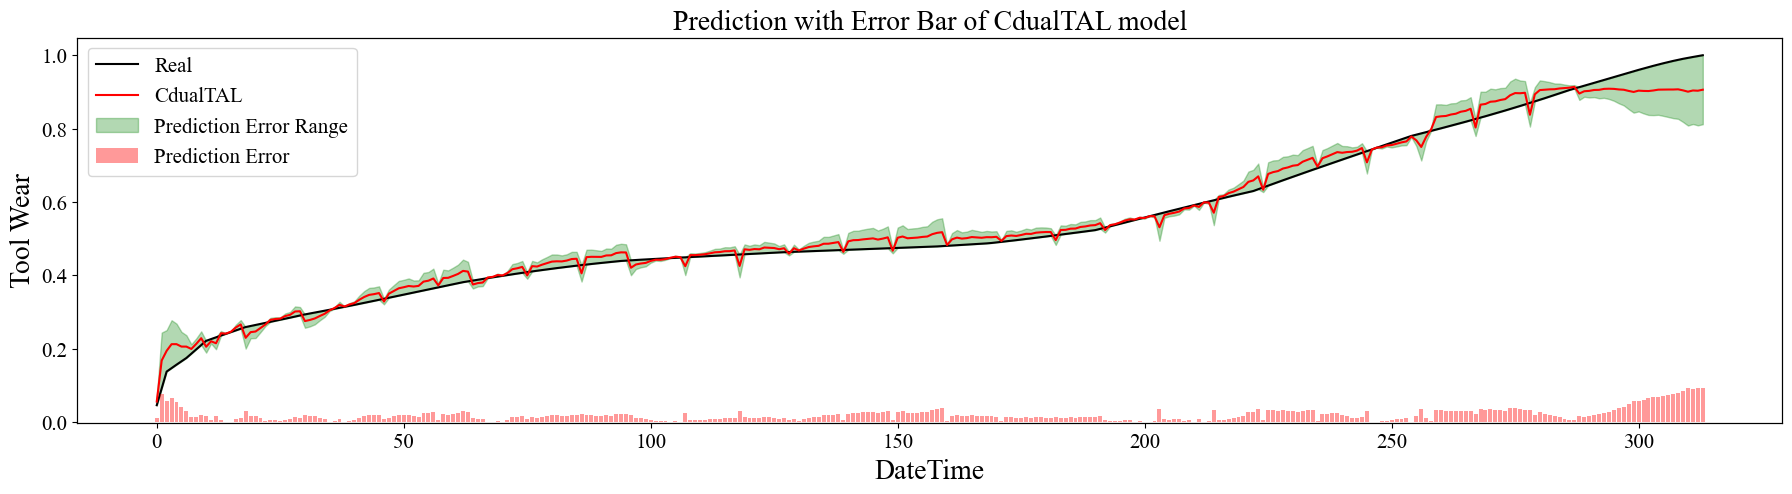

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
test_y_flat = test_y.flatten()
predicted_CPU_flat = predicted_df.flatten()
error_margin = np.abs(test_y_flat[:] - predicted_CPU_flat[:])
fig, ax1 = plt.subplots(figsize=(22, 5))
line1, = ax1.plot(test_y_flat[:], color='black', label='Real')
line2, = ax1.plot(predicted_CPU_flat[:], color='red', label='CdualTAL')
fill = ax1.fill_between(range(len(predicted_CPU_flat[:])), 
                        predicted_CPU_flat[:] - error_margin, 
                        predicted_CPU_flat[:] + error_margin, 
                        color='green', alpha=0.3, label='Prediction Error Range')
ax1.set_title('Prediction with Error Bar of CdualTAL model', fontsize=20)
ax1.set_xlabel('DateTime', fontsize=20)
ax1.set_ylabel('Tool Wear', fontsize=20)
ax2 = ax1.twinx()
bars = ax2.bar(range(len(error_margin)), error_margin, color='red', alpha=0.4, label='Prediction Error')
ax2.set_ylim(ax1.get_ylim()) 
ax2.set_yticks([])     
lines = [line1, line2, fill, bars]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=15)
plt.show()

In [18]:
def normal_label(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = np.zeros(np.shape(data))
    m = data.shape[0]
    normData = data - np.tile(minVals, (m, 1))
    normData = normData / np.tile(ranges, (m, 1))
    return normData[0], minVals, ranges
data_y61, minVals, ranges = normal_label(data_y6)
data_y61 = data_y61[1:]
def denormalize(norm_data, minVals, ranges):
    return norm_data * ranges + minVals
Test_y2 = denormalize(test_y_flat, minVals, ranges)
Predicted_CPU2 = denormalize(predicted_CPU_flat, minVals, ranges)

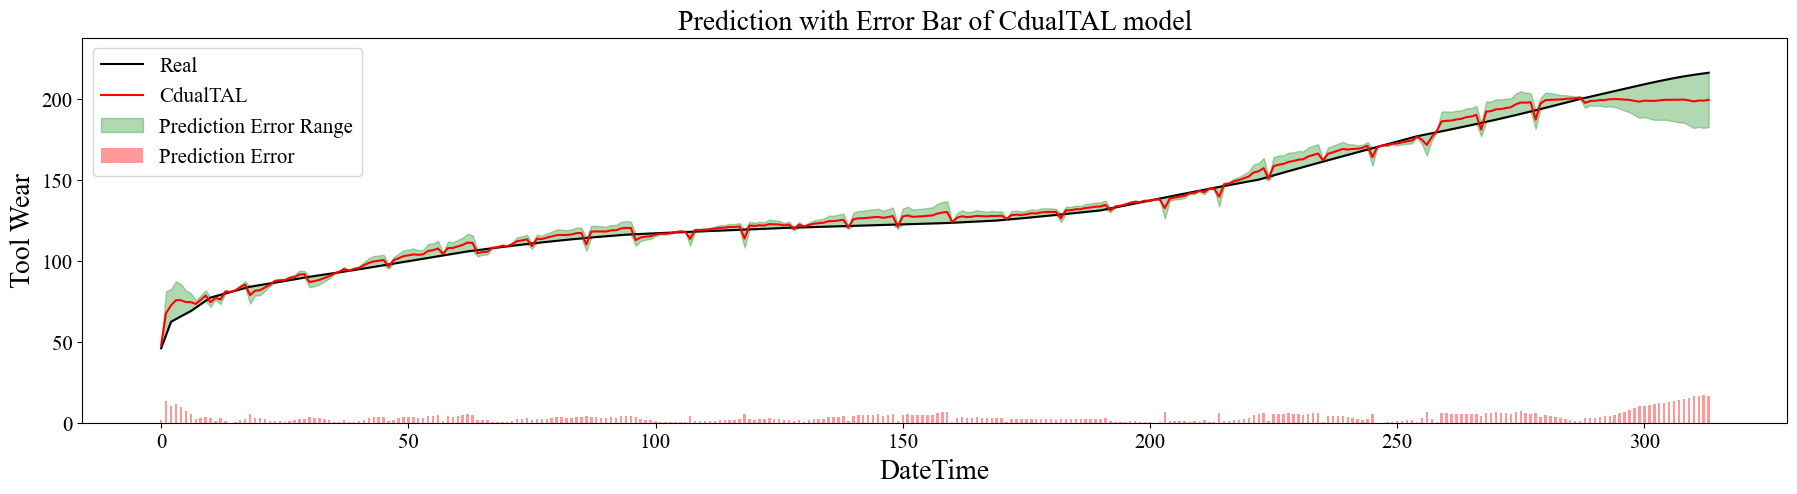

In [19]:
import pandas as pd
test_y_flat2 = Test_y2.flatten()
predicted_CPU_flat2 = Predicted_CPU2.flatten()
error_margin = np.abs(test_y_flat2 - predicted_CPU_flat2)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
fig, ax1 = plt.subplots(figsize=(22, 5))
line1, = ax1.plot(test_y_flat2[:], color='black', label='Real')
line2, = ax1.plot(predicted_CPU_flat2[:], color='red', label='CdualTAL')
fill = ax1.fill_between(range(len(predicted_CPU_flat2[:])), 
                        predicted_CPU_flat2[:] - error_margin, 
                        predicted_CPU_flat2[:] + error_margin, 
                        color='green', alpha=0.3, label='Prediction Error Range')
bars = ax1.bar(range(len(error_margin)), error_margin, color='red', alpha=0.4, label='Prediction Error', width=0.5)
ax1.set_title('Prediction with Error Bar of CdualTAL model', fontsize=20)
ax1.set_xlabel('DateTime', fontsize=20)
ax1.set_ylabel('Tool Wear', fontsize=20)
ax1.set_ylim(0, max(max(test_y_flat2), max(predicted_CPU_flat2)) * 1.1)
lines = [line1, line2, fill, bars]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=15)
plt.show()

In [20]:
import numpy
test_score = numpy.sqrt(mean_squared_error(test_y_flat2, predicted_CPU_flat2))
print('Test Score: %.2f RMSE' % test_score)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
def calculate_nse(observed, simulated):
    if len(observed) != len(simulated):
        raise ValueError("观测值和模拟值的长度不一致")
    mean_observed = sum(observed) / len(observed)
    numerator = sum((obs - sim) ** 2 for obs, sim in zip(observed, simulated))
    denominator = sum((obs - mean_observed) ** 2 for obs in observed)
    nse = 1 - (numerator / denominator)
    return nse
observed_values = test_y_flat2
simulated_values = predicted_CPU_flat2
nse_result = calculate_nse(observed_values, simulated_values)
print("NSE 值:", nse_result)
from sklearn.metrics import r2_score
test_score = r2_score(test_y_flat2,  predicted_CPU_flat2)
print('R2值: %.2f' % test_score)
mae = mean_absolute_error(test_y_flat2, predicted_CPU_flat2)
print("MAE值: ", mae)

Test Score: 4.66 RMSE
NSE 值: 0.9848610733749534
R2值: 0.98
MAE值:  3.5144343958051647
